# Analysis Code 

At first, I load all the libraries we will need later on.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pylhe

In [2]:
matplotlib.rcParams.update({'font.size': 15})

In [3]:
def smear(central, sigma):
    factor=0
    while factor<=0.05: factor=np.random.normal(1, sigma)
    return central*factor
    
def fit(E0, E1, sigma=0.3):
    
    # Smear
    E0_data = smear(E0, sigma)
    E1_data = smear(E1, sigma)
    Eh_data = smear(E0-E1, sigma)
    
    def chi2(params):
        E0_est, E1_est = params
        Eh_est  = E0_est - E1_est
        output  = ((E0_data - E0_est) / sigma)**2
        output += ((E1_data - E1_est) / sigma)**2
        output += ((Eh_data - Eh_est) / sigma)**2
        return output
    
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0]},           # a0 > 0
        {'type': 'ineq', 'fun': lambda x: x[1]},           # b0 > 0
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]}      # a0 - b0 > 0
    ]
    
    # Perform the fit
    initial_guess = [E0, E1]
    result = minimize(chi2, initial_guess,constraints=constraints)
    E0_fit, E1_fit = result.x
    
    # Output the results
    return E0_data, E1_data, E0_fit, E1_fit

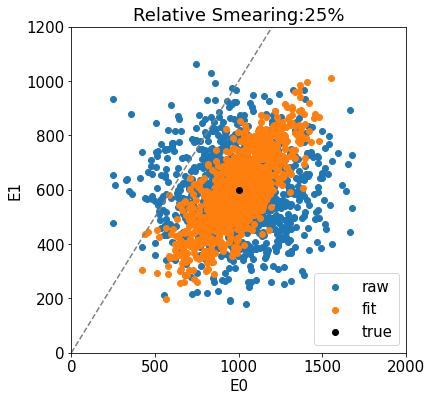

In [4]:
E0, E1, sigma = 1000, 600, 0.25

datas = []
for i in range(1000):
    E0_data, E1_data, E0_fit, E1_fit = fit(E0, E1, sigma)
    datas.append([E0_data, E1_data, E0_fit, E1_fit])
datas=np.array(datas)


# plot figure
fig = plt.figure(figsize=(6,6))
plt.scatter(datas.T[0], datas.T[1], c="C0", label=r'raw')
plt.scatter(datas.T[2], datas.T[3], c="C1", label=r'fit')
plt.scatter([E0],[E1], c="k" , label=r'true')
plt.plot([0,1200],[0,1200],c='gray', ls='dashed')
plt.xlim(0, 2000)
plt.ylim(0, 1200)
plt.xlabel("E0")
plt.ylabel("E1")
plt.title("Relative Smearing:" + str(round(sigma*100)) + "%" )
plt.legend()
plt.show()

In [7]:
def kinematics(E0, E1, th):
    
    mmu=0.105
    PZ0, PT0 = np.sqrt(E0**2-mmu**2), 0
    PZ1, PT1 = np.sqrt(E1**2-mmu**2)*np.cos(th), np.sqrt(E1**2-mmu**2)*np.sin(th)
    PZ0, PT0 = E0, 0
    PZ1, PT1 = E1*np.cos(th), E1*np.sin(th)
    
    m  = 0.938
    q2 = (PZ0-PZ1)**2+(PT0-PT1)**2-(E0-E1)**2
    v  = E0-E1
    x  = q2 / (2*m*v)
    y  = v / E0
    w2 = m**2 + q2*(1-x)/x
    
    return x,y,q2

def read_file(filename = "pwgevents.lhe", sigma=0.25, irepeat=10):

    # read 
    event_input = list(pylhe.read_lhe_with_attributes("pwgevents.lhe"))
    print("Number of events:", len(event_input))
    
    #loop through events
    output=[]
    for event in event_input: 
        E0 = event.particles[0].e
        E1 = event.particles[2].e
        th = np.sqrt(event.particles[2].px**2 + event.particles[2].py**2)/event.particles[2].pz
        
        #smear and fit
        for i in range(irepeat):
            E0_data, E1_data, E0_fit, E1_fit = fit(E0, E1, sigma)
            #kinematics
            x_truth, y_truth, q2_truth = kinematics(E0, E1, th)
            x_data, y_data, q2_data = kinematics(E0_data, E1_data, th)
            x_fit, y_fit, q2_fit = kinematics(E0_fit, E1_fit, th)
            output.append([x_truth, x_data, x_fit])

    return np.array(output)

data = read_file(sigma=0.3, irepeat=10)

WARNING. Parse Error: junk after document element: line 1859, column 1
Number of events: 100


/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


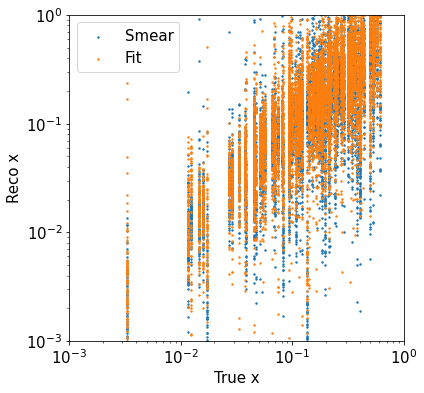

In [8]:
# plot figure
fig = plt.figure(figsize=(6,6))
plt.scatter(data.T[0], data.T[1], label=r'Smear', s=2)
plt.scatter(data.T[0], data.T[2], label=r'Fit',   s=2)
plt.xlim(1e-3,1)
plt.ylim(1e-3,1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True x")
plt.ylabel("Reco x")
plt.legend()
plt.show()

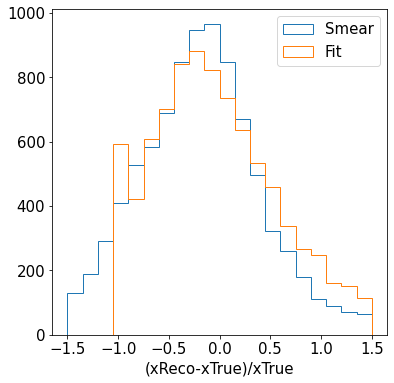

In [9]:
# plot figure
diff1 = [(x1-x0)/x0 for x0,x1,_ in data]
diff2 = [(x1-x0)/x0 for x0,_,x1 in data]

fig = plt.figure(figsize=(6,6))
plt.hist(diff1, label=r'Smear', histtype='step', bins=np.linspace(-1.5,1.5,21))
plt.hist(diff2, label=r'Fit'  , histtype='step', bins=np.linspace(-1.5,1.5,21))
plt.xlabel("(xReco-xTrue)/xTrue")
plt.legend()
plt.show()